## Read annotation from the BioLiP text file

Each line in the annotation file BioLiP_*.txt annotates for each ligand-protein interaction site in BioLiP.  We then search the proteins in Davis datasets for pocket residue info. Ref to NodeCoder `build_biolip_df` function. 

The columns are (from left to right):
- 01	PDB ID
- 02	Receptor chain
- 03	Resolution. "-1.00" stands for lack of resolution information, e.g. for NMR
- 04	Binding site number code
- 05	Ligand ID in the Chemical Component Dictionary (CCD) used by the PDB database
- 06	Ligand chain
- 07	Ligand serial number
- 08      Binding site residues (with PDB residue numbering)
- 09      Binding site residues (with residue re-numbered starting from 1)
- 10	Catalytic site residues (different sites are separated by ';') (with PDB residue numbering)
- 11      Catalytic site residues (different sites are separated by ';') (with residue re-numbered starting from 1)
- 12	EC number
- 13	GO terms
- 14	Binding affinity by manual survey of the original literature. The information in '()' is the PubMed ID
- 15	Binding affinity provided by the Binding MOAD database. The information in '()' is the ligand information in Binding MOAD
- 16	Binding affinity provided by the PDBbind-CN database. The information in '()' is the ligand information in PDBbind-CN
- 17	Binding affinity provided by the BindingDB database
- 18	UniProt ID
- 19	PubMed ID
- 20	Residue sequence number of the ligand (field _atom_site.auth_seq_id in PDBx/mmCIF format)
- 21	Receptor sequence

Download the BioLip text from web

In [1]:
import pickle
import torch
from tqdm import tqdm
import pandas as pd
from torchdrug import data, utils

data_path = "../../../data/dta-datasets/Davis/"
biolip_file = "../../../data/dta-datasets/Davis/BioLiP/BioLiP.txt"

In [2]:
protein_df = pd.read_csv(f'{data_path}davis_proteins.csv')
protein_df

,Gene,Sequence,Accession Number,Entrez Gene Symbol,PDBID,AA length,Original ID,Original AA
0,AAK1,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,NP_055726.3,AAK1,Q2M2I8,961,NaN,NaN
1,ABL1(E255K),PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,NP_005148.2,ABL1,Q59FK4,1167,P00519,NaN
2,ABL1(F317I),PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,NP_005148.2,ABL1,Q59FK4,1167,P00519,NaN
3,ABL1(F317I)p,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,NP_005148.2,ABL1,Q59FK4,1167,P00519,NaN
4,ABL1(F317L),PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,NP_005148.2,ABL1,Q59FK4,1167,P00519,NaN
...,...,...,...,...,...,...,...,...
437,YES,MGCIKSKENKSPAIKYRPENTPEPVSTSVSHYGAEPTTVSPCPSSS...,NP_005424.1,YES1,P07947,543,NaN,NaN
438,YSK1,MAHLRGFANQHSRVDPEELFTKLDRIGKGSFGEVYKGIDNHTKEVV...,NP_006365.2,STK25,O00506,426,NaN,NaN
439,YSK4,MSSMPKPERHAESLLDICHDTNSSPTDLMTVTKNQNIILQSISRSE...,NP_079328.3,YSK4,Q56UN5,1328,NaN,NaN
440,ZAK,MSSLGASFVQIKFDDLQFFENCGGGSFGSVYRAKWISQDKEVAVKK...,NP_598407.1,ZAK,Q9NYL2,800,NaN,NaN


从第8项提取原始的结合residue例如H57就表示第57个残基是H，通过将所有匹配UniProt ID的行进行筛选

需要注意的是由于这里使用`UniProtID`进行匹配，可能出现没有匹配的项，看看怎么解决！
- 找不到的蛋白质替换为`Swiss-Prot`的版本，注意对齐残基序列

In [3]:
label_list = [] 
empty_list =[]
pdbs = protein_df["PDBID"].tolist() 
indexes = range(len(pdbs))
indexes = tqdm(indexes, "Constructing Pocket from PDB: ")
for index in indexes:
    pdb_id = pdbs[index]
    # print("========== Current PDB:" + pdb_id + " ==========")
    # residue_seq = protein_df.at[index, "Sequence"]
    # Read Biolip File
    current_pocket = []
    current_dict = {pdb_id: current_pocket}
    with open(biolip_file) as F:
        for line in F:
            # each line is a entry for DTA, fileds is a list contains all info
            fields = line.strip('\n').split('\t')
            uniprot_id = fields[17] 
            # receptor_seq = fields[20]
            # First match the UniProt ID
            if uniprot_id == pdb_id:
                residue_list = fields[7].split()  # [7] Binding site residues
                for residue in residue_list:
                    raw_number = int(residue[1:]) - 1
                    if raw_number not in current_pocket: # and raw_number < len(residue_seq):
                        current_pocket.append(raw_number)  # start with 0
            # Next check whether seq is the substring
    label_list.append(current_dict)
    # elif receptor_seq in residue_seq:
    #     begin_index = residue_seq.find(receptor_seq)
    #     residue_list = fields[7].split()  # [7] Binding site residues
    #     for residue in residue_list:
    #         raw_number = int(residue[1:]) - 1 + begin_index
    #         if raw_number not in current_pocket and raw_number < len(residue_seq):
    #             current_pocket.append(raw_number)  # start with begin_index
    
    # label = torch.zeros(len(residue_seq))
    # print("========== Current Pocket:" + str(len(current_pocket)) + " ==========")
    # if len(current_pocket) == 0:
    #     empty_list.append(pdbs[index])
    # else:
    #     current_pocket.sort()
    #     for index in current_pocket:
    #         label[index] = 1
    # label_list.append(label)

Constructing Pocket from PDB:   2%|▏         | 10/442 [00:40<28:52,  4.01s/it]


KeyboardInterrupt: 

In [ ]:
label_list

[{'Q2M2I8': [184,
   185,
   188,
   126,
   175,
   193,
   52,
   59,
   71,
   73,
   125,
   127,
   128,
   131,
   132,
   179,
   182,
   192,
   51,
   135,
   103,
   49,
   93,
   53,
   57]},
 {'Q59FK4': []},
 {'Q59FK4': []},
 {'Q59FK4': []},
 {'Q59FK4': []},
 {'Q59FK4': []},
 {'Q59FK4': []},
 {'Q59FK4': []},
 {'Q59FK4': []},
 {'Q59FK4': []},
 {'Q59FK4': []},
 {'Q59FK4': []},
 {'Q59FK4': []},
 {'Q59FK4': []},
 {'Q59FK4': []},
 {'Q59FK4': []},
 {'P42684': [293,
   298,
   301,
   314,
   360,
   361,
   362,
   363,
   364,
   365,
   366,
   415,
   426,
   335,
   351,
   352,
   354,
   356,
   436,
   437,
   458,
   460,
   462,
   464,
   525,
   526,
   316,
   445,
   448,
   491,
   494,
   331,
   358,
   405,
   406,
   425,
   427,
   382,
   383,
   385,
   386,
   478,
   508,
   510,
   513,
   294,
   413]},
 {'Q04771': [213,
   232,
   262,
   284,
   285,
   288,
   342,
   234,
   282,
   289,
   292,
   353,
   280,
   339,
   352,
   221,
   286,
   272,


In [ ]:
final_dict = {}
for dict in label_list:
    final_dict.update(dict)

In [ ]:
final_dict

{'Q2M2I8': [184,
  185,
  188,
  126,
  175,
  193,
  52,
  59,
  71,
  73,
  125,
  127,
  128,
  131,
  132,
  179,
  182,
  192,
  51,
  135,
  103,
  49,
  93,
  53,
  57],
 'Q59FK4': [],
 'P42684': [293,
  298,
  301,
  314,
  360,
  361,
  362,
  363,
  364,
  365,
  366,
  415,
  426,
  335,
  351,
  352,
  354,
  356,
  436,
  437,
  458,
  460,
  462,
  464,
  525,
  526,
  316,
  445,
  448,
  491,
  494,
  331,
  358,
  405,
  406,
  425,
  427,
  382,
  383,
  385,
  386,
  478,
  508,
  510,
  513,
  294,
  413],
 'Q04771': [213,
  232,
  262,
  284,
  285,
  288,
  342,
  234,
  282,
  289,
  292,
  353,
  280,
  339,
  352,
  221,
  286,
  272,
  273,
  412,
  415,
  426,
  427,
  283,
  218,
  203,
  205,
  226,
  265,
  321,
  328,
  329,
  361,
  363,
  364,
  201,
  204,
  255,
  256,
  257,
  317,
  258,
  259,
  261,
  263,
  344,
  350,
  324,
  327,
  246,
  249,
  250,
  358,
  359,
  492,
  495,
  335,
  374,
  387,
  448,
  287,
  293,
  307,
  343,
  347,
  3

In [ ]:
import json
output_file = "../../../data/dta-datasets/Davis/BioLiP/Pocket_label.json"
with open(output_file, 'w') as json_file:
    json.dump(final_dict, json_file)

In [ ]:
len(label_list)

440

In [ ]:
label_list

[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
         0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
         0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.,

In [ ]:
empty_list

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 18,
 23,
 26,
 30,
 31,
 33,
 39,
 40,
 47,
 48,
 49,
 61,
 62,
 63,
 64,
 66,
 79,
 87,
 95,
 100,
 101,
 106,
 124,
 125,
 129,
 130,
 132,
 134,
 136,
 137,
 144,
 146,
 148,
 153,
 154,
 165,
 166,
 170,
 172,
 176,
 179,
 181,
 182,
 186,
 188,
 208,
 209,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 225,
 226,
 229,
 231,
 232,
 236,
 239,
 241,
 248,
 252,
 254,
 255,
 256,
 264,
 265,
 266,
 268,
 269,
 271,
 273,
 275,
 276,
 277,
 278,
 280,
 281,
 282,
 289,
 294,
 295,
 296,
 298,
 300,
 301,
 302,
 303,
 304,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 314,
 315,
 316,
 317,
 318,
 324,
 325,
 326,
 330,
 340,
 344,
 345,
 346,
 350,
 361,
 364,
 365,
 369,
 370,
 376,
 377,
 381,
 382,
 383,
 384,
 385,
 387,
 388,
 390,
 393,
 395,
 396,
 397,
 398,
 401,
 402,
 406,
 409,
 411,
 414,
 418,
 420,
 421,
 423,
 426,
 435,
 436,
 437,
 439]

In [ ]:
label_list

[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
         0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.,

In [ ]:
zero_tensors = [tensor for tensor in label_list if (tensor == 0).all()]
zero_tensors

[tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
len(zero_tensors)

163

In [ ]:
label_pkl = '../../../data/dta-datasets/Davis/pocket_label.pkl'
with utils.smart_open(label_pkl, "wb") as fout:
    pickle.dump(label_list, fout)

## Dataset Pockets Lable From P2Rank

这里参考 `TorchProtein` 里的 tutorial2 Task2 示例，参考`SecondaryStructure`构建数据集

- ✅Pocket Protein List comes from the davis dataset file.

In [ ]:
import pickle
import torch
from tqdm import tqdm
import pandas as pd
import numpy as np
from torchdrug import data, utils

path = "../../../data/dta-datasets/Davis/"
dataset_file = "../../../data/dta-datasets/Davis/davis_filtered_datasets.csv"

In [ ]:
dataset_df = pd.read_csv(dataset_file)
dataset_df

,Unnamed: 0,Drug_ID,Drug,Target_ID,Target,Y,PDB_File,Drug_Index,protein_Index
0,0,11314340,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,AAK1,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,7.366532,AF-Q2M2I8-F1-model_v4.pdb,0,0
1,24,11314340,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,AKT1,MSDVAIVKEGWLHKRGEYIKTWRPRYFLLKNDGTFIGYKERPQDVD...,7.119186,AF-P31749-F1-model_v4.pdb,0,24
2,25,11314340,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,AKT2,MNEVSVIKEGWLHKRGEYIKTWRPRYFLLKSDGSFIGYKERPEAPD...,5.537602,AF-P31751-F1-model_v4.pdb,0,25
3,26,11314340,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,AKT3,MSDVTIVKEGWVQKRGEYIKNWRPRYFLLKTDGSFIGYKEKPQDVD...,6.744727,AF-Q9Y243-F1-model_v4.pdb,0,26
4,36,11314340,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,AURKC,MSSPRAVVQLGKAQPAGEELATANQTAQQPSSPAMRRLTVDDFEIG...,5.075721,AF-Q9UQB9-F1-model_v4.pdb,0,36
...,...,...,...,...,...,...,...,...,...
9120,29912,151194,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,PDGFRB,AASEPDTAGSVRGLPTAHCPVVQDNRTLGDSSAGEIALSTRNVSET...,7.602060,AF-P09619-F1-model_v4.pdb,67,298
9121,29970,151194,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,RET(M918T),MAKATSGAAGLRLLLLLLLPLLGKVALGLYFSRDAYWEKLYVDQAA...,5.119186,AF-P07949-F1-model_v4.pdb,67,356
9122,30044,151194,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,VEGFR2,MQSKVLLAVALWLCVETRAASVGLPSVSLDLPRLSIQKDILTIKAN...,7.207608,AF-P35968-F1-model_v4.pdb,67,430
9123,30053,151194,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,YSK4,MSSMPKPERHAESLLDICHDTNSSPTDLMTVTKNQNIILQSISRSE...,5.721246,AF-Q56UN5-F1-model_v4.pdb,67,439


In [ ]:
dataset_df["PDB_File"].shape[0]

9125

In [ ]:
dataset_df["PDB_File"][1].split(".")[0] 

'AF-P31749-F1-model_v4'

In [ ]:
label_list = []
indexes = range(dataset_df["PDB_File"].shape[0])  # dataset_df["PDB_File"].shape[0]
indexes = tqdm(indexes, "Constructing Pocket from PDB: ")
for index in indexes:
    label_dict = {}
    csv_file = path + 'p2rank/predict_protein_list/' + dataset_df["PDB_File"][index].split(".")[0] + '.pdb_residues.csv'
    pdb_residues = pd.read_csv(csv_file)
    pdb_residues.columns = pdb_residues.columns.str.strip()

    label_dict['mask'] = np.ones(pdb_residues['pocket'].shape[0], dtype='int32')  # all true
    label_dict['target'] = np.zeros(pdb_residues['pocket'].shape[0], dtype='int32')  

    for i in range(pdb_residues["pocket"].shape[0]):
        if pdb_residues['pocket'][i] != 0:
            label_dict['target'][i] = 1
    label_list.append(label_dict)

Constructing Pocket from PDB: 100%|██████████| 9125/9125 [01:19<00:00, 115.04it/s]


In [ ]:
label_list[0]

{'mask': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
label_list[2]['mask']

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
len(label_list)

9125

from protein index into dataset index

In [ ]:
label_pkl = '../../../data/dta-datasets/Davis/pocket_label.pkl'
with utils.smart_open(label_pkl, "wb") as fout:
    pickle.dump(label_list, fout)

## Pocket Label From UniProt Sites File

- ✅Pocket Protein List comes from the davis dataset file.

In [1]:
import pickle
import torch
import json
from tqdm import tqdm
import pandas as pd
import numpy as np
from torchdrug import data, utils

path = "../../../data/dta-datasets/Davis/"
dataset_file = "../../../data/dta-datasets/Davis/davis_filtered_datasets.csv"
protein_file = "../../../data/dta-datasets/Davis/davis_proteins.csv"

In [2]:
label_dict = json.load(open(f"{path}BioLiP/pocket_label.txt"))

In [3]:
label_dict['Q2M2I8']

[52, 53, 54, 55, 56, 57, 58, 59, 60, 74, 176]

In [4]:
# label_dict.keys()

In [4]:
dataset_df = pd.read_csv(dataset_file)
dataset_df

,Unnamed: 0,Drug_ID,Drug,Target_ID,Target,Y,PDB_File,Drug_Index,protein_Index
0,0,11314340,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,AAK1,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,7.366532,AF-Q2M2I8-F1-model_v4.pdb,0,0
1,24,11314340,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,AKT1,MSDVAIVKEGWLHKRGEYIKTWRPRYFLLKNDGTFIGYKERPQDVD...,7.119186,AF-P31749-F1-model_v4.pdb,0,24
2,25,11314340,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,AKT2,MNEVSVIKEGWLHKRGEYIKTWRPRYFLLKSDGSFIGYKERPEAPD...,5.537602,AF-P31751-F1-model_v4.pdb,0,25
3,26,11314340,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,AKT3,MSDVTIVKEGWVQKRGEYIKNWRPRYFLLKTDGSFIGYKEKPQDVD...,6.744727,AF-Q9Y243-F1-model_v4.pdb,0,26
4,36,11314340,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,AURKC,MSSPRAVVQLGKAQPAGEELATANQTAQQPSSPAMRRLTVDDFEIG...,5.075721,AF-Q9UQB9-F1-model_v4.pdb,0,36
...,...,...,...,...,...,...,...,...,...
9120,29912,151194,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,PDGFRB,AASEPDTAGSVRGLPTAHCPVVQDNRTLGDSSAGEIALSTRNVSET...,7.602060,AF-P09619-F1-model_v4.pdb,67,298
9121,29970,151194,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,RET(M918T),MAKATSGAAGLRLLLLLLLPLLGKVALGLYFSRDAYWEKLYVDQAA...,5.119186,AF-P07949-F1-model_v4.pdb,67,356
9122,30044,151194,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,VEGFR2,MQSKVLLAVALWLCVETRAASVGLPSVSLDLPRLSIQKDILTIKAN...,7.207608,AF-P35968-F1-model_v4.pdb,67,430
9123,30053,151194,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,YSK4,MSSMPKPERHAESLLDICHDTNSSPTDLMTVTKNQNIILQSISRSE...,5.721246,AF-Q56UN5-F1-model_v4.pdb,67,439


In [5]:
dataset_df["PDB_File"].shape[0]

9125

In [6]:
protein_df = pd.read_csv(protein_file)
protein_df

,Gene,Sequence,Accession Number,Entrez Gene Symbol,PDBID,AA length,Original ID,Original AA
0,AAK1,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,NP_055726.3,AAK1,Q2M2I8,961,NaN,NaN
1,ABL1(E255K),PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,NP_005148.2,ABL1,Q59FK4,1167,P00519,NaN
2,ABL1(F317I),PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,NP_005148.2,ABL1,Q59FK4,1167,P00519,NaN
3,ABL1(F317I)p,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,NP_005148.2,ABL1,Q59FK4,1167,P00519,NaN
4,ABL1(F317L),PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,NP_005148.2,ABL1,Q59FK4,1167,P00519,NaN
...,...,...,...,...,...,...,...,...
437,YES,MGCIKSKENKSPAIKYRPENTPEPVSTSVSHYGAEPTTVSPCPSSS...,NP_005424.1,YES1,P07947,543,NaN,NaN
438,YSK1,MAHLRGFANQHSRVDPEELFTKLDRIGKGSFGEVYKGIDNHTKEVV...,NP_006365.2,STK25,O00506,426,NaN,NaN
439,YSK4,MSSMPKPERHAESLLDICHDTNSSPTDLMTVTKNQNIILQSISRSE...,NP_079328.3,YSK4,Q56UN5,1328,NaN,NaN
440,ZAK,MSSLGASFVQIKFDDLQFFENCGGGSFGSVYRAKWISQDKEVAVKK...,NP_598407.1,ZAK,Q9NYL2,800,NaN,NaN


In [7]:
protein_df['PDBID'][0]

'Q2M2I8'

In [8]:
protein_df['AA length'][417]

796

In [9]:
with utils.smart_open(f"{path}gearnet_Protein.pkl", "rb") as fin:
    target_protein = pickle.load(fin)

In [10]:
len(target_protein)

442

In [12]:
target_protein[0].num_residue.item()

961

In [13]:
label_list = []
indexes = range(dataset_df["PDB_File"].shape[0])  # dataset_df["PDB_File"].shape[0]
indexes = tqdm(indexes, "Constructing Pocket from File: ")
for index in indexes:
    pdb_index = dataset_df["protein_Index"][index]
    current_pdb = protein_df['PDBID'][pdb_index]
    current_pocket = label_dict[current_pdb]
    current_length = target_protein[pdb_index].num_residue.item()

    pocket_dict = {}
    pocket_dict['mask'] = np.ones(current_length, dtype='int32')  # all true
    pocket_dict['target'] = np.zeros(current_length, dtype='int32')  
    # if current_pocket[-1] > current_length:
    #     print(current_pdb, current_pocket[-1], current_length)
    for pocket_index in current_pocket:
        pocket_dict['target'][pocket_index - 1] = 1
    label_list.append(pocket_dict)

Constructing Pocket from File: 100%|██████████| 9125/9125 [00:00<00:00, 20387.66it/s]


In [1]:
len('MLRGGRRGQLGWHSWAAGPGSLLAWLILASAGAAPCPDACCPHGSSGLRCTRDGALDSLHHLPGAENLTELYIENQQHLQHLELRDLRGLGELRNLTIVKSGLRFVAPDAFHFTPRLSRLNLSFNALESLSWKTVQGLSLQELVLSGNPLHCSCALRWLQRWEEEGLGGVPEQKLQCHGQGPLAHMPNASCGVPTLKVQVPNASVDVGDDVLLRCQVEGRGLEQAGWILTELEQSATVMKSGGLPSLGLTLANVTSDLNRKNVTCWAENDVGRAEVSVQVNVSFPASVQLHTAVEMHHWCIPFSVDGQPAPSLRWLFNGSVLNETSFIFTEFLEPAANETVRHGCLRLNQPTHVNNGNYTLLAANPFGQASASIMAAFMDNPFEFNPEDPIPDTNSTSGDPVEKKDETPFGVSVAVGLAVFACLFLSTLLLVLNKCGRRNKFGINRPAVLAPEDGLAMSLHFMTLGGSSLSPTEGKGSGLQGHIIENPQYFSDACVHHIKRRDIVLKWELGEGAFGKVFLAECHNLLPEQDKMLVAVKALKEASESARQDFQREAELLTMLQHQHIVRFFGVCTEGRPLLMVFEYMRHGDLNRFLRSHGPDAKLLAGGEDVAPGPLGLGQLLAVASQVAAGMVYLAGLHFVHRDLATRNCLVGQGLVVKIGDFGMSRDIYSTDYYRVGGRTMLPIRWMPPESILYRKFTTESDVWSFGVVLWEIFTYGKQPWYQLSNTEAIDCITQGRELERPRACPPEVYAIMRGCWQREPQQRHSIKDVHARLQALAQAPPVYLDVLG')

790

In [14]:
label_list[253]['mask'].shape

(415,)

In [14]:
label_list[0]['mask']

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [15]:
len(label_list)

9125

from protein index into dataset index

In [16]:
label_pkl = '../../../data/dta-datasets/Davis/pocket_uniprot_label.pkl'
with utils.smart_open(label_pkl, "wb") as fout:
    pickle.dump(label_list, fout)

- ✅Pocket Protein List with 442 labeled proteins.

In [1]:
import pickle
import json
from tqdm import tqdm
import pandas as pd
import numpy as np
from torchdrug import utils

path = "../../../data/dta-datasets/Davis/"
protein_file = "../../../data/dta-datasets/Davis/davis_proteins.csv"
protein_pkl = '../../../data/dta-datasets/Davis/gearnetesm650m_Protein.pkl'

In [2]:
with utils.smart_open(protein_pkl, "rb") as fin:
    protein_list = pickle.load(fin)

In [3]:
len(protein_list)

442

In [4]:
protein_list

[PackedProtein(batch_size=1, num_atoms=[961], num_bonds=[11102], num_residues=[961]),
 PackedProtein(batch_size=1, num_atoms=[1167], num_bonds=[15017], num_residues=[1167]),
 PackedProtein(batch_size=1, num_atoms=[1167], num_bonds=[15017], num_residues=[1167]),
 PackedProtein(batch_size=1, num_atoms=[1167], num_bonds=[15017], num_residues=[1167]),
 PackedProtein(batch_size=1, num_atoms=[1167], num_bonds=[15017], num_residues=[1167]),
 PackedProtein(batch_size=1, num_atoms=[1167], num_bonds=[15017], num_residues=[1167]),
 PackedProtein(batch_size=1, num_atoms=[1167], num_bonds=[15017], num_residues=[1167]),
 PackedProtein(batch_size=1, num_atoms=[1167], num_bonds=[15017], num_residues=[1167]),
 PackedProtein(batch_size=1, num_atoms=[1167], num_bonds=[15017], num_residues=[1167]),
 PackedProtein(batch_size=1, num_atoms=[1167], num_bonds=[15017], num_residues=[1167]),
 PackedProtein(batch_size=1, num_atoms=[1167], num_bonds=[15017], num_residues=[1167]),
 PackedProtein(batch_size=1, num_a

In [5]:
label_dict = json.load(open(f"{path}BioLiP/pocket_label.txt"))

In [6]:
total_nums = 0
for value in label_dict.values():
    total_nums += len(value)

In [7]:
total_nums

4755

In [8]:
label_dict['Q2M2I8']

[52, 53, 54, 55, 56, 57, 58, 59, 60, 74, 176]

In [9]:
protein_df = pd.read_csv(protein_file)
protein_df

,Gene,Sequence,Accession Number,Entrez Gene Symbol,PDBID,AA length,Original ID,Original AA
0,AAK1,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,NP_055726.3,AAK1,Q2M2I8,961,NaN,NaN
1,ABL1(E255K),PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,NP_005148.2,ABL1,Q59FK4,1167,P00519,NaN
2,ABL1(F317I),PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,NP_005148.2,ABL1,Q59FK4,1167,P00519,NaN
3,ABL1(F317I)p,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,NP_005148.2,ABL1,Q59FK4,1167,P00519,NaN
4,ABL1(F317L),PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,NP_005148.2,ABL1,Q59FK4,1167,P00519,NaN
...,...,...,...,...,...,...,...,...
437,YES,MGCIKSKENKSPAIKYRPENTPEPVSTSVSHYGAEPTTVSPCPSSS...,NP_005424.1,YES1,P07947,543,NaN,NaN
438,YSK1,MAHLRGFANQHSRVDPEELFTKLDRIGKGSFGEVYKGIDNHTKEVV...,NP_006365.2,STK25,O00506,426,NaN,NaN
439,YSK4,MSSMPKPERHAESLLDICHDTNSSPTDLMTVTKNQNIILQSISRSE...,NP_079328.3,YSK4,Q56UN5,1328,NaN,NaN
440,ZAK,MSSLGASFVQIKFDDLQFFENCGGGSFGSVYRAKWISQDKEVAVKK...,NP_598407.1,ZAK,Q9NYL2,800,NaN,NaN


In [10]:
protein_df['PDBID'][0]

'Q2M2I8'

In [17]:
label_list = []
pocket_list = []
indexes = range(protein_df["PDBID"].shape[0])
indexes = tqdm(indexes, "Constructing Pocket from File: ")
for index in indexes:
    current_pdb = protein_df['PDBID'][index]
    pocket_key = label_dict[current_pdb]
    current_pocket = [x - 1 for x in pocket_key]
    current_protein = protein_list[index]
    current_length = current_protein.num_residue.item()
    pocket = current_protein.residue_mask(index=current_pocket, compact=True)
    pocket_list.append(pocket)

    pocket_dict = {}
    pocket_dict['mask'] = np.ones(current_length, dtype='int32')  # all true
    pocket_dict['target'] = np.zeros(current_length, dtype='int32')  
    for pocket_index in current_pocket:
        pocket_dict['target'][pocket_index] = 1
    label_list.append(pocket_dict)

Constructing Pocket from File: 100%|██████████| 442/442 [00:00<00:00, 751.75it/s]


In [18]:
len(label_list)

442

In [19]:
len(pocket_list)

442

In [20]:
pocket_list

[PackedProtein(batch_size=1, num_atoms=[11], num_bonds=[89], num_residues=[11]),
 PackedProtein(batch_size=1, num_atoms=[27], num_bonds=[137], num_residues=[27]),
 PackedProtein(batch_size=1, num_atoms=[27], num_bonds=[137], num_residues=[27]),
 PackedProtein(batch_size=1, num_atoms=[27], num_bonds=[137], num_residues=[27]),
 PackedProtein(batch_size=1, num_atoms=[27], num_bonds=[137], num_residues=[27]),
 PackedProtein(batch_size=1, num_atoms=[27], num_bonds=[137], num_residues=[27]),
 PackedProtein(batch_size=1, num_atoms=[27], num_bonds=[137], num_residues=[27]),
 PackedProtein(batch_size=1, num_atoms=[27], num_bonds=[137], num_residues=[27]),
 PackedProtein(batch_size=1, num_atoms=[27], num_bonds=[137], num_residues=[27]),
 PackedProtein(batch_size=1, num_atoms=[27], num_bonds=[137], num_residues=[27]),
 PackedProtein(batch_size=1, num_atoms=[27], num_bonds=[137], num_residues=[27]),
 PackedProtein(batch_size=1, num_atoms=[27], num_bonds=[137], num_residues=[27]),
 PackedProtein(ba

In [21]:
label_list[0]

{'mask': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1

In [13]:
label_pkl = '../../../data/dta-datasets/Davis/gearnet_labeled.pkl'
with utils.smart_open(label_pkl, "wb") as fout:
    pickle.dump(label_list, fout)

In [22]:
pocket_pkl = '../../../data/dta-datasets/Davis/gearnetesm_labeledpocket_Protein.pkl'
with utils.smart_open(pocket_pkl, "wb") as fout:
    pickle.dump(pocket_list, fout)

## Pocket Prediction Performance with P2Rank

Get the label

In [1]:
import torch
import pickle
import json
from tqdm import tqdm
import pandas as pd
import numpy as np
from torchdrug import utils, metrics

path = "../../../data/dta-datasets/Davis/"
protein_file = "../../../data/dta-datasets/Davis/davis_proteins.csv"

In [2]:
label_pkl = '../../../data/dta-datasets/Davis/gearnet_labeled.pkl'
with utils.smart_open(label_pkl, "rb") as fin:
    label_list = pickle.load(fin)

In [3]:
len(label_list)

442

In [4]:
label_list[0]

{'mask': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1

Get the prediction from P2Rank

In [5]:
protein_df = pd.read_csv(protein_file, usecols=['Gene', 'PDBID'])
protein_df

,Gene,PDBID
0,AAK1,Q2M2I8
1,ABL1(E255K),Q59FK4
2,ABL1(F317I),Q59FK4
3,ABL1(F317I)p,Q59FK4
4,ABL1(F317L),Q59FK4
...,...,...
437,YES,P07947
438,YSK1,O00506
439,YSK4,Q56UN5
440,ZAK,Q9NYL2


In [6]:
def map_nonzero_to_one(x):
    if x != 0:
        return 1
    else:
        return 0

In [7]:
csv_file = path + 'p2rank/predict_protein_list/AF-Q2M2I8-F1-model_v4.pdb_residues.csv'
pdb_residues = pd.read_csv(csv_file)
pdb_residues.columns = pdb_residues.columns.str.strip()

In [8]:
pdb_residues

,chain,residue_label,residue_name,score,zscore,probability,pocket
0,A,1,MET,1.1339,0.1873,0.1371,2
1,A,2,LYS,0.8196,0.0261,0.0730,0
2,A,3,LYS,0.2384,-0.2722,0.0069,0
3,A,4,PHE,0.6481,-0.0619,0.0459,0
4,A,5,PHE,1.5669,0.4095,0.2385,3
...,...,...,...,...,...,...,...
956,A,957,GLN,0.0296,-0.3793,0.0004,0
957,A,958,LEU,0.1529,-0.3160,0.0032,0
958,A,959,ILE,0.5123,-0.1316,0.0287,5
959,A,960,ASP,0.2387,-0.2720,0.0069,0


In [9]:
pdb_residues['pocket'] = pdb_residues['pocket'].apply(map_nonzero_to_one)

In [10]:
pdb_residues

,chain,residue_label,residue_name,score,zscore,probability,pocket
0,A,1,MET,1.1339,0.1873,0.1371,1
1,A,2,LYS,0.8196,0.0261,0.0730,0
2,A,3,LYS,0.2384,-0.2722,0.0069,0
3,A,4,PHE,0.6481,-0.0619,0.0459,0
4,A,5,PHE,1.5669,0.4095,0.2385,1
...,...,...,...,...,...,...,...
956,A,957,GLN,0.0296,-0.3793,0.0004,0
957,A,958,LEU,0.1529,-0.3160,0.0032,0
958,A,959,ILE,0.5123,-0.1316,0.0287,1
959,A,960,ASP,0.2387,-0.2720,0.0069,0


In [11]:
auprc_list = []
auroc_list =[]
pdbs = protein_df["PDBID"].tolist() 
indexes = range(len(pdbs))
indexes = tqdm(indexes, "Cal the AUR and PRC from CSV: ")
for index in indexes:
    # get the label
    current_target = label_list[index]
    target = torch.as_tensor(current_target['target'], dtype=torch.long)
    mask = torch.as_tensor(current_target["mask"], dtype=torch.bool)
    labeled = ~torch.isnan(target) & mask
    # get the pred
    pdb_name = pdbs[index]
    csv_file = path + 'p2rank/predict_protein_list/AF-' + pdbs[index] + '-F1-model_v4.pdb_residues.csv'
    pdb_residues = pd.read_csv(csv_file)
    pdb_residues.columns = pdb_residues.columns.str.strip()
    # pred_list = pdb_residues["probability"].tolist()
    pred_list = pdb_residues['pocket'].apply(map_nonzero_to_one)
    pred = torch.as_tensor(pred_list, dtype=torch.float32)
    # if target.shape[0] != target.shape[0]:
    #     print("Error") 
    # get the result
    current_auprc = metrics.area_under_prc(pred[labeled], target[labeled])
    auprc_list.append(current_auprc)
    current_auroc = metrics.area_under_roc(pred[labeled], target[labeled])
    auroc_list.append(current_auroc)

Cal the AUR and PRC from CSV: 100%|██████████| 442/442 [00:01<00:00, 419.77it/s]


use the pocket line

In [12]:
# get the mean result
AUPRC = sum(auprc_list) / len(auprc_list)
AUPRC

tensor(0.1169)

In [13]:
AUROC = sum(auroc_list) / len(auroc_list)
AUROC

tensor(0.7935)

use the pro line

In [8]:
# get the mean result
AUPRC = sum(auprc_list) / len(auprc_list)
AUPRC

tensor(0.2055)

In [9]:
AUROC = sum(auroc_list) / len(auroc_list)
AUROC

tensor(0.8455)

## Protein Feature

### DSSP feature

In [ ]:
import Bio.PDB
import Bio.PDB.Chain
import Bio.SeqUtils
import subprocess
import os
import pandas as pd
import freesasa
import gzip
from Bio import SwissProt
from Bio.PDB import DSSP
from Bio.PDB.Polypeptide import PPBuilder
from Bio.PDB.Model import Model
from loguru import logger
from tempfile import NamedTemporaryFile

freesasa.setVerbosity(freesasa.nowarnings)

In [ ]:
def load_alphafold_index(alphafold_folder: str) -> pd.DataFrame:
    """
    Summarizes content from an folder with an unpacked alphafold proteome tar file
    :param alphafold_folder: Directory of alphafold pdb files
    :return: formatted dataframe of models which can be used for representation
    """
    logger.info(f"Reading Alphafold Files: {alphafold_folder}")
    model_files = [x for x in os.listdir(alphafold_folder) if x.endswith('.pdb.gz')]
    logger.info(f"  -> Parsed {len(model_files)}; Sample 3: {model_files[0:3]}")
    logger.info(f"  -> Total Unique Uniprots {len(set(model_files))}")

    model_file_df = pd.DataFrame([x.strip('.pdb.gz').split('-') for x in model_files],
                                 columns=['tag', 'accession', 'file_number', 'model_code'])
    model_file_df['file_name'] = model_files
    logger.info(f"  -> Generated Model Dataframe:\n{model_file_df}")
    return model_file_df

In [ ]:
def sasa_occupancy(pdb_entity):
    """
    Populates the 'occupancy' column with SASA in Å² via the occupancy field in the biopython atom object
    :param pdb_entity: Any biopython entity with atoms
    """
    # Now we run freesasa and load the results in the occupancy field of the atom
    asa_engine = freesasa.Structure()
    atom_list = [atom for atom in pdb_entity.get_atoms()]
    for i in range(0, len(atom_list)):
        atom = atom_list[i]
        name = f'{atom.element:>2s}'
        resid = (str(atom.parent.id[1])+atom.parent.id[2]).strip()
        (x, y, z) = atom.coord
        asa_engine.addAtom(name, atom.parent.resname, resid, atom.parent.parent.id, x, y, z)
    if asa_engine.nAtoms() > 0:
        result = freesasa.calc(asa_engine)
        for i in range(0, len(atom_list)):
            atom = atom_list[i]
            atom.set_occupancy(result.atomArea(i))

In [ ]:
def sequence_features(uniprot_object, pdb_chain, dssp):
    """
    Examines the feature records of a protein to generate structure-based features
    :param uniprot_object: Swissprot record parsed by SwissProt.parse(fileIO)
    :param pdb_chain: bio.pdb chain object with 3d coordinates corresponding to the relevant chain
    :param dssp: DSSP object from the dssp_from_filename object below
    :return: sequence dataframe with columns corresponding to observed features
    """
    # Build a dictionary dataframe to get started, one-hot encode sequence
    labels = {'annotation_sequence': list(uniprot_object.sequence)}
    n = len(uniprot_object.sequence)
    for aa_type in 'ACDEFGHIKLMNPQRSTVWY':
        labels[f'feat_{aa_type}'] = [False] * n
    for i, aa in enumerate(uniprot_object.sequence):
        try:
            labels[f"feat_{aa}"][i] = True
        except KeyError:
            logger.warning(f"Non-standard AA {aa} in sequence {uniprot_object.sequence}")

    # Now for sasa, and atomreq biolip_sequence and phi, psi, omega
    ppb = PPBuilder()
    sasa_occupancy(pdb_chain)
    mapping = protein_sequences.sequence_structure_mapping(uniprot_object.sequence, pdb_chain)
    if mapping is None:
        logger.warning(f"Unable to map atomrec onto uniprot for {uniprot_object.entry_name}. Skipping.")
        return None
    seq_to_atom, atom_to_seq = mapping
    backbone = ['CA', 'C', 'O', 'N']
    labels['annotation_atomrec'] = [None] * n
    for feature in ['feat_PHI', 'feat_PSI', 'feat_TAU', 'feat_THETA', 'feat_BBSASA', 'feat_SCSASA', 'feat_pLDDT']:
        labels[feature] = [0] * n
    for d_char in ['H', 'B', 'E', 'G', 'I', 'T', 'S']:
        labels[f'feat_DSSP_{d_char}'] = [False] * n
    for d_prop in range(6, 14):
        labels[f'feat_DSSP_{d_prop}'] = [0] * n

    for coord in ['coord_X', 'coord_Y', 'coord_Z']:
        labels[coord] = [0] * n
    no_ss = 0
    all_ss = 0
    for peptide in ppb.build_peptides(pdb_chain):
        seqs = peptide.get_sequence()
        taus = peptide.get_tau_list()
        thetas = peptide.get_theta_list()
        phis, psis = zip(*peptide.get_phi_psi_list())
        for res, aa, phi, psi, tau, theta in zip(peptide, seqs, phis, psis, taus, thetas):
            ref_index = atom_to_seq[res.id[1]]
            sasa = sum([x.occupancy for x in res])
            bb_sasa = sum([res[x].occupancy for x in backbone])
            sc_sasa = sasa - bb_sasa
            labels['annotation_atomrec'][ref_index] = aa
            labels['feat_PHI'][ref_index] = phi if phi else 0
            labels['feat_PSI'][ref_index] = psi if psi else 0
            labels['feat_TAU'][ref_index] = tau if tau else 0
            labels['feat_THETA'][ref_index] = theta if theta else 0
            labels['feat_BBSASA'][ref_index] = bb_sasa
            labels['feat_SCSASA'][ref_index] = sc_sasa
            labels['coord_X'][ref_index] = res['CA'].coord[0]
            labels['coord_Y'][ref_index] = res['CA'].coord[1]
            labels['coord_Z'][ref_index] = res['CA'].coord[2]
            labels['feat_pLDDT'][ref_index] = res['CA'].bfactor
            try:
                dssp_res = dssp[(res.parent.id, res.id)]
                for d_char in ['H', 'B', 'E', 'G', 'I', 'T', 'S']:
                    labels[f'feat_DSSP_{d_char}'][ref_index] = d_char == dssp_res[2]
                for d_prop in range(6, 14):
                    labels[f'feat_DSSP_{d_prop}'][ref_index] = dssp_res[d_prop]
            except KeyError:
                no_ss += 1
            all_ss += 1

    # Create dataframe and return
    return pd.DataFrame(labels)

In [ ]:
def dssp_from_filename(model: Model, full_path: str) -> DSSP:
    """
    A wrapper to get biopython's dssp working with alphafold files.  DSSP has some unnecessary pdb files formatting
    restrictions that require me to remove the model and endmdl lines, and the biopython DSSP parser isn't behaving well
    so i mimic'd direct submission of a dssp file.
    :param full_path: absolute filepath of alphafold pdb file
    :param model: corresponding biopython model object for the relevant ss assignment
    """

    with NamedTemporaryFile(suffix='.pdb') as temp_pdb:
        with gzip.open(full_path, 'rt') as PDB_FILE:
            for line in PDB_FILE:
                if line.startswith('ENDMDL'):
                    temp_pdb.write(b'END')
                    break
                if not line.startswith('MODEL'):
                    temp_pdb.write(line.encode())
        p = subprocess.Popen(["mkdssp", temp_pdb.name], universal_newlines=True,
                             stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        out, err = p.communicate()
    with NamedTemporaryFile(suffix='.dssp') as temp_dssp:
        temp_dssp.write(out.encode())
        dssp_obj = DSSP(model, temp_dssp.name, file_type='DSSP')
    return dssp_obj

In [ ]:
def feature_dataframe(uniprot_object, model_path):
    """
    Generates a feature dataframe for the given uniprot object and saves it to disk.
    :param uniprot_object: swissprot protein object
    :param model_path: full disk path of the model file to featurize
    :return feature dataframe where each row is a residue and each column is a feature or coordinates to build network
    """
    # Step1. structure parse
    with gzip.open(model_path, 'rt') as F:
        parser = Bio.PDB.PDBParser(QUIET=True)
        structure = parser.get_structure('????', F)
    # Step2. dssp feature
    dssp = dssp_from_filename(structure[0], model_path)
    chains = sorted(structure[0].child_list, key=lambda y: len(y), reverse=True)
    assert len(chains) == 1  # The SM version sometimes had bound peptides and we defaulted to longest seg
    chain = chains[0]        # For alphafold however, there should only be one chain and no empty dataframes
    return sequence_features(uniprot_object, chain, dssp)

test for residue feature

test for SAS points of the protein

## Combine mol with protein into complex graph

In [1]:
import torch
from torchdrug import datasets, data, layers
from rdkit import Chem

In [2]:
pdb_file = "../../../data/dta-datasets/Davis/pdb/AF-Q2M2I8-F1-model_v4.pdb"

In [4]:
mol = Chem.MolFromPDBFile(pdb_file, sanitize=False)

In [5]:
protein = data.Molecule.from_molecule(mol, atom_feature='default', bond_feature='default', mol_feature=None) 
protein

Molecule(num_atom=7306, num_bond=14932)

In [6]:
torch.ones([protein.num_atom.item()])

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [7]:
with protein.atom():  # 在molecule文件中进行了对应的修改，注意1表示来自蛋白质，0表示来自药物
    protein.atom_source = torch.ones([protein.num_atom.item()])

In [8]:
protein.atom_source[0]

tensor(1.)

In [9]:
protein.atom_feature.shape

torch.Size([7306, 67])

In [10]:
protein.node_position

tensor([[17.2050, 10.3060, -8.6160],
        [16.3900, 10.9010, -9.7030],
        [16.3170, 12.4280, -9.6660],
        ...,
        [-1.8630, 25.3010, 15.0980],
        [-3.2940, 25.3450, 17.1060],
        [-7.0560, 23.4570, 14.7120]])

In [11]:
protein.node_position.shape

torch.Size([7306, 3])

In [12]:
smiles = "CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N"

In [13]:
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
Chem.AllChem.EmbedMolecule(mol, randomSeed=42)  
Chem.rdForceFieldHelpers.MMFFOptimizeMolecule(mol)
mol = Chem.RemoveHs(mol)
molecule = data.Molecule.from_molecule(mol, atom_feature='default', bond_feature='default', mol_feature=None) 
with molecule.atom():
    molecule.node_position = torch.tensor([data.feature.atom_position(atom) for atom in mol.GetAtoms()])
    molecule.atom_source = torch.zeros([molecule.num_atom.item()])

In [14]:
molecule

Molecule(num_atom=27, num_bond=60)

In [15]:
molecule.atom_feature.shape

torch.Size([27, 67])

In [16]:
molecule.node_position

tensor([[ 7.0568, -1.6281,  1.2653],
        [ 6.5467, -0.9575,  0.0497],
        [ 5.4408, -0.1885, -0.2070],
        [ 4.4570,  0.1631,  0.7140],
        [ 3.4385,  0.9662,  0.1358],
        [ 3.4717,  1.3480, -1.2557],
        [ 4.4877,  0.9745, -2.1679],
        [ 5.4926,  0.1795, -1.5985],
        [ 6.5923, -0.3512, -2.1554],
        [ 7.1977, -1.0176, -1.1548],
        [ 2.3178,  1.4194,  0.9770],
        [ 0.9855,  1.1110,  0.6549],
        [-0.0567,  1.5474,  1.4709],
        [ 0.2809,  2.2883,  2.5978],
        [ 1.5458,  2.6125,  2.9521],
        [ 2.5282,  2.1714,  2.1336],
        [-1.3887,  1.3210,  1.2807],
        [-1.7620,  0.5446,  0.1361],
        [-3.3016,  0.4005,  0.1140],
        [-3.7324, -0.4775, -1.0802],
        [-5.1035, -1.0929, -0.9191],
        [-6.2578, -0.3459, -1.1877],
        [-7.5231, -0.9151, -1.0347],
        [-7.6476, -2.2362, -0.6101],
        [-6.5071, -2.9878, -0.3348],
        [-5.2409, -2.4194, -0.4863],
        [-3.9419,  1.7335,  0.0655]])

In [17]:
molecule.node_position.shape

torch.Size([27, 3])

In [18]:
molecule.atom_source

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])

`merge(graph2graph)`Merge multiple graphs into a single graph.

In [19]:
interaction_graph = data.Molecule.pack([molecule, protein])
interaction_graph

PackedMolecule(batch_size=2, num_atoms=[27, 7306], num_bonds=[60, 14932])

In [20]:
complex_graph = interaction_graph.merge([0, 0])  # merge two graph into one single graph
complex_graph

PackedMolecule(batch_size=1, num_atoms=[7333], num_bonds=[14992])

In [21]:
complex_graph.atom_source.tolist()

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

通过索引就能提取复合体中药物的坐标

In [22]:
complex_graph.atom_source == 0

tensor([ True,  True,  True,  ..., False, False, False])

In [23]:
drug_center = complex_graph.node_position[complex_graph.atom_source == 0].mean(dim=0)  # 药物分子的中心坐标
drug_center

tensor([0.3473, 0.1542, 0.0132])

[TODO]
- 怎么做到2个分子之间初始状态下不干涉！
- 怎么区分蛋白质的原子和药物的原子！✅

从  `Molecule` 和 `Protein` 通过 `GraphConstruction` 构建$2$类结点 [蛋白质原子，药物分子原子]以及$3$类边 [分子内共价键（短程），分子内分子键（长程），分子间亲和键（长程）]

`GraphConstruction` 采样方式：
- 结点：药物使用 `IdentityNode`，蛋白质使用距离 `SubspaceNode ` （仅包含10A内的原子，才有可能产生相互作用）
- 边：分子内部使用 `BondEdge`，分子间使用 `SpatialEdge` 来代表空间作用，最后使用 `KNNEdge` 连接增加连通性，方便消息传递

In [33]:
graph_construction_model = layers.GraphConstruction(node_layers=[layers.geometry.PocketNode(center_coords=drug_center)], 
                                                    edge_layers=[layers.geometry.BondEdge(), 
                                                                 layers.geometry.SpatialEdge(radius=5.0, min_distance=2, max_distance=10, mode="atoms")],
                                                    edge_feature="molecule")

✅TODO  
可能需要对于 `SubspaceNode` 中随机的结点代码进行修改，修改为以药物中心为半径的采样方式。对于药物分子的所有原子都不变，仅对蛋白质的原子使用球体空间采样，拼接为一个`PackedMolcule`

In [25]:
complex_graph

PackedMolecule(batch_size=1, num_atoms=[7333], num_bonds=[14992])

In [31]:
complex_graph.node2graph

tensor([0, 0, 0,  ..., 0, 0, 0])

In [34]:
transGraph = graph_construction_model(complex_graph)
transGraph

PackedMolecule(batch_size=1, num_atoms=[233], num_bonds=[5219])

Spatialedge Mode   
- r=10 PackedMolecule(batch_size=1, num_atoms=[233], num_bonds=[7455])
- r=5 PackedMolecule(batch_size=1, num_atoms=[233], num_bonds=[5219])

### Protein in Molecule format pkl file

In [6]:
import torch
import pickle
import pandas as pd
from tqdm import tqdm
from torchdrug import data, utils
from rdkit import Chem

path = "../../../data/dta-datasets/Davis/"
protein_file = "../../../data/dta-datasets/Davis/davis_proteins.csv"

In [2]:
protein_df = pd.read_csv(protein_file, usecols=['Sequence', 'PDBID'])
protein_df

,Sequence,PDBID
0,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,Q2M2I8
1,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,Q59FK4
2,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,Q59FK4
3,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,Q59FK4
4,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,Q59FK4
...,...,...
437,MGCIKSKENKSPAIKYRPENTPEPVSTSVSHYGAEPTTVSPCPSSS...,P07947
438,MAHLRGFANQHSRVDPEELFTKLDRIGKGSFGEVYKGIDNHTKEVV...,O00506
439,MSSMPKPERHAESLLDICHDTNSSPTDLMTVTKNQNIILQSISRSE...,Q56UN5
440,MSSLGASFVQIKFDDLQFFENCGGGSFGSVYRAKWISQDKEVAVKK...,Q9NYL2


In [7]:
new_list = [] 
pdbs = protein_df["PDBID"].tolist() 
indexes = range(len(pdbs))
indexes = tqdm(indexes, "Constructing Pocket from PDB: ")
for index in indexes:
    pdb_file = path + 'pdb/AF-' + pdbs[index] + '-F1-model_v4.pdb'
    mol = Chem.MolFromPDBFile(pdb_file, sanitize=False)
    protein = data.Molecule.from_molecule(mol, atom_feature='default', bond_feature='default', mol_feature=None) 
    with protein.atom():
        protein.atom_source = torch.ones([protein.num_atom.item()])
    new_list.append(protein)

Constructing Pocket from PDB: 100%|██████████| 442/442 [03:30<00:00,  2.10it/s]


In [8]:
new_list

[Molecule(num_atom=7306, num_bond=14932),
 Molecule(num_atom=8961, num_bond=18354),
 Molecule(num_atom=8961, num_bond=18354),
 Molecule(num_atom=8961, num_bond=18354),
 Molecule(num_atom=8961, num_bond=18354),
 Molecule(num_atom=8961, num_bond=18354),
 Molecule(num_atom=8961, num_bond=18354),
 Molecule(num_atom=8961, num_bond=18354),
 Molecule(num_atom=8961, num_bond=18354),
 Molecule(num_atom=8961, num_bond=18354),
 Molecule(num_atom=8961, num_bond=18354),
 Molecule(num_atom=8961, num_bond=18354),
 Molecule(num_atom=8961, num_bond=18354),
 Molecule(num_atom=8961, num_bond=18354),
 Molecule(num_atom=8961, num_bond=18354),
 Molecule(num_atom=8961, num_bond=18354),
 Molecule(num_atom=9023, num_bond=18462),
 Molecule(num_atom=4001, num_bond=8178),
 Molecule(num_atom=3984, num_bond=8156),
 Molecule(num_atom=4058, num_bond=8330),
 Molecule(num_atom=4057, num_bond=8340),
 Molecule(num_atom=3938, num_bond=8062),
 Molecule(num_atom=5062, num_bond=10350),
 Molecule(num_atom=4227, num_bond=8642)

In [9]:
protein_pkl = '../../../data/dta-datasets/Davis/ProteinInMolecule_Protein.pkl'
with utils.smart_open(protein_pkl, "wb") as fout:
    pickle.dump(new_list, fout)

### Molecule in Molecule format pkl file

In [1]:
import torch
import pickle
import pandas as pd
from tqdm import tqdm
from torchdrug import data, utils
from rdkit import Chem

path = "../../../data/dta-datasets/Davis/"
drug_file = "../../../data/dta-datasets/Davis/davis_ligands.csv"

In [3]:
drug_df = pd.read_csv(drug_file, usecols=['PubChemID', 'SMILES'])
drug_df

,PubChemID,SMILES
0,11314340,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...
1,24889392,CC(C)(C)C1=CC(=NO1)NC(=O)NC2=CC=C(C=C2)C3=CN4C...
2,11409972,CCN1CCN(CC1)CC2=C(C=C(C=C2)NC(=O)NC3=CC=C(C=C3...
3,11338033,C1CNCCC1NC(=O)C2=C(C=NN2)NC(=O)C3=C(C=CC=C3Cl)Cl
4,10184653,CN(C)CC=CC(=O)NC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC(...
...,...,...
63,5494449,CC1=CC(=NN1)NC2=NC(=NC(=C2)N3CCN(CC3)C)SC4=CC=...
64,3038525,C1=CC(=C(C(=C1)Cl)C2=C3C=CC(=NN3C=NC2=O)SC4=C(...
65,3081361,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...
66,9809715,CN1CCN(CC1)CC(=O)N(C)C2=CC=C(C=C2)NC(=C3C4=C(C...


In [7]:
new_list = [] 
smiles_list = drug_df["SMILES"].tolist() 
indexes = range(len(smiles_list))
indexes = tqdm(indexes, "Constructing Molecule from SMILES: ")
for index in indexes:
    smiles = smiles_list[index]
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    Chem.AllChem.EmbedMolecule(mol, randomSeed=42)
    Chem.rdForceFieldHelpers.MMFFOptimizeMolecule(mol)
    mol = Chem.RemoveHs(mol)
    molecule = data.Molecule.from_molecule(mol, atom_feature='default', bond_feature='default', mol_feature=None)
    with molecule.atom():
        molecule.node_position = torch.tensor([data.feature.atom_position(atom) for atom in mol.GetAtoms()])
        molecule.atom_source = torch.zeros([molecule.num_atom.item()])
    new_list.append(molecule)

Constructing Molecule from SMILES: 100%|██████████| 68/68 [00:08<00:00,  7.57it/s]


In [8]:
new_list

[Molecule(num_atom=27, num_bond=60),
 Molecule(num_atom=40, num_bond=90),
 Molecule(num_atom=38, num_bond=82),
 Molecule(num_atom=25, num_bond=54),
 Molecule(num_atom=34, num_bond=74),
 Molecule(num_atom=28, num_bond=62),
 Molecule(num_atom=28, num_bond=62),
 Molecule(num_atom=38, num_bond=84),
 Molecule(num_atom=20, num_bond=42),
 Molecule(num_atom=37, num_bond=80),
 Molecule(num_atom=36, num_bond=78),
 Molecule(num_atom=27, num_bond=60),
 Molecule(num_atom=37, num_bond=82),
 Molecule(num_atom=25, num_bond=54),
 Molecule(num_atom=34, num_bond=74),
 Molecule(num_atom=33, num_bond=74),
 Molecule(num_atom=30, num_bond=66),
 Molecule(num_atom=33, num_bond=72),
 Molecule(num_atom=39, num_bond=86),
 Molecule(num_atom=36, num_bond=76),
 Molecule(num_atom=39, num_bond=90),
 Molecule(num_atom=29, num_bond=62),
 Molecule(num_atom=46, num_bond=102),
 Molecule(num_atom=25, num_bond=56),
 Molecule(num_atom=31, num_bond=68),
 Molecule(num_atom=27, num_bond=58),
 Molecule(num_atom=31, num_bond=68),


In [9]:
drug_pkl = '../../../data/dta-datasets/Davis/DrugInMolecule_Molecule.pkl'
with utils.smart_open(drug_pkl, "wb") as fout:
    pickle.dump(new_list, fout)

: 

### Coords updating

In [1]:
import pickle
import torch
from torchdrug import utils

In [2]:
coords_lists = []
for index in range(3):
    coords_file = '../../../data/dta-datasets/Davis/EGNN_Coords/coords_epoch' + str(index) + '.pkl'
    with utils.smart_open(coords_file, "rb") as fin:
        coords_lists.append(pickle.load(fin))

In [3]:
coords_lists[0][0].shape

torch.Size([1021, 3])

In [4]:
coords_lists[0][0]

tensor([[ 2.0579,  3.5117,  2.2535],
        [ 3.2155,  2.9182,  1.3819],
        [ 3.0872,  1.5966,  1.0026],
        ...,
        [ 6.9352,  2.5129, -1.5132],
        [ 8.4070,  0.6109, -2.1290],
        [ 8.5936,  1.6106,  0.3404]], device='cuda:0')

In [5]:
coords_lists[1][0]

tensor([[ 1.9397,  3.5724,  2.3425],
        [ 3.2699,  2.9481,  1.3607],
        [ 3.0823,  1.5563,  0.9895],
        ...,
        [ 6.9182,  2.5486, -1.5241],
        [ 8.4312,  0.5934, -2.1571],
        [ 8.7559,  1.6685,  0.5669]], device='cuda:0')

In [6]:
coords_lists[2][0]

tensor([[ 1.5275,  3.7658,  2.6467],
        [ 3.4865,  3.0817,  1.2819],
        [ 3.0684,  1.4026,  0.9280],
        ...,
        [ 6.8046,  2.8019, -1.6077],
        [ 8.6024,  0.4787, -2.3600],
        [ 9.1990,  1.8356,  1.1580]], device='cuda:0')

+=========END=========+

✅TODO  11.07  
将RMSD加入到loss中，这里的RMSD用于衡量，随机初始化（SMILES生成）的分子坐标与真实的分子（PDBbind中mol文件生成）坐标之间的差距。

In [1]:
import pickle
import torch
from rdkit import Chem
from torchdrug import utils

In [2]:
molecule_pkl = '../../../data/dta-datasets/PDBbind/3d_Molecule.pkl'
with utils.smart_open(molecule_pkl, "rb") as fin:
    molecule_label = pickle.load(fin)

In [3]:
molecule_pkl = '../../../data/dta-datasets/PDBbind/3dNoise_Molecule.pkl'
with utils.smart_open(molecule_pkl, "rb") as fin:
    molecule_noise = pickle.load(fin)

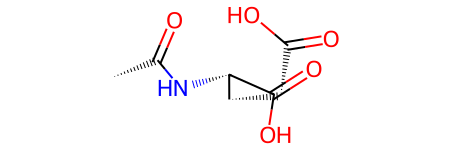

In [4]:
molecule_label[0].to_molecule()

In [5]:
molecule_label[0].node_position

tensor([[ 6.3750, 32.3070,  2.4190],
        [ 7.5560, 31.7840,  1.5760],
        [ 8.6130, 32.4600,  1.6000],
        [ 7.3940, 30.7200,  0.9280],
        [ 6.3780, 31.6520,  3.8030],
        [ 7.7310, 31.7390,  4.5120],
        [ 7.9290, 33.0690,  5.2440],
        [ 9.0660, 33.2520,  5.7170],
        [ 6.9720, 33.8800,  5.2850],
        [ 4.4860, 32.6870,  0.8540],
        [ 3.2690, 32.2260,  0.3460],
        [ 4.9360, 33.7430,  0.4210],
        [ 5.0950, 31.9550,  1.7810]])

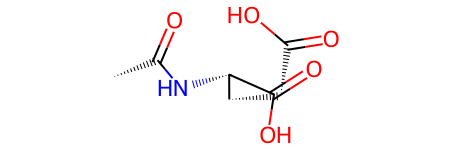

In [6]:
molecule_noise[0].to_molecule()

In [7]:
molecule_noise[0].node_position

tensor([[33.1544, 59.0863, 29.1984],
        [34.3354, 58.5634, 28.3554],
        [35.3923, 59.2393, 28.3794],
        [34.1734, 57.4994, 27.7073],
        [33.1573, 58.4314, 30.5823],
        [34.5103, 58.5183, 31.2914],
        [34.7084, 59.8484, 32.0233],
        [35.8454, 60.0313, 32.4963],
        [33.7514, 60.6594, 32.0644],
        [31.2654, 59.4664, 27.6334],
        [30.0484, 59.0054, 27.1254],
        [31.7154, 60.5224, 27.2003],
        [31.8743, 58.7344, 28.5604]])

In [12]:
# 计算每对原子间的欧几里得距离
differences = molecule_label[0].node_position[:, None, :] - molecule_noise[0].node_position[None, :, :]
differences

tensor([[[-26.7794, -26.7794, -26.7794],
         [-27.9604, -26.2564, -25.9363],
         [-29.0173, -26.9324, -25.9604],
         [-27.7984, -25.1924, -25.2883],
         [-26.7823, -26.1244, -28.1633],
         [-28.1353, -26.2113, -28.8724],
         [-28.3334, -27.5414, -29.6043],
         [-29.4704, -27.7243, -30.0773],
         [-27.3764, -28.3524, -29.6453],
         [-24.8904, -27.1594, -25.2143],
         [-23.6734, -26.6984, -24.7064],
         [-25.3404, -28.2154, -24.7813],
         [-25.4993, -26.4274, -26.1413]],

        [[-25.5984, -27.3023, -27.6224],
         [-26.7794, -26.7794, -26.7794],
         [-27.8363, -27.4553, -26.8034],
         [-26.6174, -25.7154, -26.1313],
         [-25.6013, -26.6474, -29.0063],
         [-26.9543, -26.7343, -29.7154],
         [-27.1524, -28.0644, -30.4473],
         [-28.2894, -28.2473, -30.9203],
         [-26.1954, -28.8754, -30.4883],
         [-23.7094, -27.6824, -26.0574],
         [-22.4924, -27.2214, -25.5494],
         [-24.

In [13]:
dist_squared = torch.sum(differences ** 2, dim=2)  # 每对原子的距离的平方
dist_squared

tensor([[2151.4009, 2143.8716, 2241.2979, 2046.9036, 2192.9502, 2312.2454,
         2437.7224, 2541.7881, 2432.1672, 1992.9233, 1883.6333, 2052.3547,
         2031.9919],
        [2163.6880, 2151.4009, 2247.0781, 2052.6101, 2206.8787, 2324.2646,
         2451.8989, 2554.2681, 2449.5217, 2007.4313, 1899.6772, 2066.1743,
         2045.8588],
        [2072.9094, 2058.8730, 2151.4009, 1961.8945, 2116.9128, 2231.2866,
         2356.6694, 2456.3647, 2355.2168, 1920.2073, 1815.6736, 1976.5920,
         1958.2924],
        [2267.4580, 2253.3481, 2350.8374, 2151.4009, 2311.0496, 2429.9775,
         2561.4553, 2665.1953, 2560.5471, 2109.3699, 1999.5820, 2169.9446,
         2147.6384],
        [2114.5403, 2108.6521, 2206.8914, 2012.0851, 2151.4006, 2268.8394,
         2394.0312, 2497.0205, 2389.4307, 1960.9039, 1852.4236, 2022.9146,
         1996.4441],
        [2003.6404, 1995.8425, 2091.0698, 1900.8180, 2038.6440, 2151.4006,
         2274.7874, 2373.9976, 2272.5774, 1857.2684, 1752.8816, 1918.4

In [14]:
# 对距离的平方求和并计算均方根
rmsd = torch.sqrt(torch.mean(dist_squared))
rmsd

tensor(46.5366)

In [11]:
Chem.AllChem.GetBestRMS(molecule_label[1].to_molecule(), molecule_noise[1].to_molecule())

2.300349003431424e-06

In [10]:
Chem.rdMolAlign.GetBestRMS(molecule_label[0].to_molecule(), molecule_noise[0].to_molecule())

1.3996112550837379e-06

molecule center coords

In [6]:
molecule.node_position

tensor([[ 7.0602, -1.6249,  1.2716],
        [ 6.5485, -0.9609,  0.0530],
        [ 5.4419, -0.1939, -0.2066],
        [ 4.4588,  0.1620,  0.7135],
        [ 3.4391,  0.9613,  0.1322],
        [ 3.4705,  1.3354, -1.2615],
        [ 4.4856,  0.9575, -2.1728],
        [ 5.4918,  0.1664, -1.6002],
        [ 6.5912, -0.3666, -2.1555],
        [ 7.1981, -1.0273, -1.1519],
        [ 2.3191,  1.4184,  0.9721],
        [ 0.9864,  1.1098,  0.6519],
        [-0.0552,  1.5502,  1.4667],
        [ 0.2835,  2.2950,  2.5906],
        [ 1.5488,  2.6195,  2.9431],
        [ 2.5305,  2.1747,  2.1258],
        [-1.3875,  1.3241,  1.2779],
        [-1.7620,  0.5460,  0.1349],
        [-3.3019,  0.4041,  0.1133],
        [-3.7342, -0.4758, -1.0789],
        [-5.1058, -1.0896, -0.9158],
        [-6.2596, -0.3417, -1.1837],
        [-7.5253, -0.9095, -1.0287],
        [-7.6507, -2.2301, -0.6028],
        [-6.5107, -2.9827, -0.3281],
        [-5.2440, -2.4157, -0.4816],
        [-3.9402,  1.7379,  0.0620]])

计算中心坐标

In [7]:
center_coords = torch.mean(molecule.node_position, dim=0)  # molecule center
center_coords

tensor([0.3473, 0.1535, 0.0126])

test the center coords for graph construct

In [8]:
node_out = torch.arange(protein.num_node, device=protein.device)
node_out

tensor([   0,    1,    2,  ..., 7303, 7304, 7305])

In [9]:
dist = (center_coords - protein.node_position[node_out]).norm(dim=-1)
dist

tensor([21.4874, 21.6165, 22.3466,  ..., 29.4084, 30.6603, 28.5296])

这里的k最好也是动态的，从蛋白质原子总数中取 1/10 最多，最少可以为0。但是会有惩罚项，就是相当于没有考虑蛋白质的话惩罚一下，但是距离太近也需要惩罚，这里得在后面的dis_matrix里进行，少于1A就不行了，产生干涉！

In [10]:
torch.topk(dist, k=int(protein.num_node / 10), largest=False)[0].shape

torch.Size([730])

In [11]:
topk_dist = torch.topk(dist, k=int(protein.num_node/20), largest=False)[0]
topk_dist

tensor([ 0.6182,  1.2561,  2.1998,  2.3631,  2.7977,  3.2910,  3.5393,  3.8095,
         3.8369,  3.8971,  3.9337,  3.9747,  4.3046,  4.4386,  4.5124,  4.5555,
         4.5593,  4.5906,  4.7264,  4.7427,  4.9798,  4.9805,  5.0559,  5.1947,
         5.2359,  5.2829,  5.3055,  5.3126,  5.3302,  5.3343,  5.5257,  5.6021,
         5.6213,  5.6787,  5.7073,  5.7185,  5.7658,  5.7698,  5.8875,  5.9104,
         5.9166,  5.9361,  5.9743,  5.9845,  6.0261,  6.1238,  6.1574,  6.2078,
         6.2490,  6.2790,  6.2996,  6.3130,  6.3290,  6.3321,  6.3472,  6.3550,
         6.3881,  6.4439,  6.4583,  6.4789,  6.4984,  6.5010,  6.5148,  6.6332,
         6.7220,  6.7289,  6.7640,  6.7748,  6.7765,  6.7827,  6.8432,  6.8758,
         6.9169,  6.9666,  7.0111,  7.0267,  7.0498,  7.0538,  7.0860,  7.0896,
         7.1869,  7.2313,  7.2642,  7.2908,  7.3019,  7.3219,  7.3276,  7.3388,
         7.3569,  7.3823,  7.4568,  7.4571,  7.4610,  7.4925,  7.5448,  7.5487,
         7.5507,  7.5933,  7.6136,  7.65

In [12]:
radius = (topk_dist[-1] * 1.5).clamp(min=2, max=20)  # 截取[2,r]之间的距离
radius

tensor(18.3617)

In [13]:
node_index = node_out[dist < radius]
node_index

tensor([ 380,  381,  382,  ..., 7261, 7262, 7263])

In [14]:
pocket = protein.subgraph(node_index)
pocket

Protein(num_atom=1026, num_bond=2004, num_residue=961)

感觉说不定不用将2个合并，通过提取pocket这一个过程就能缩小查找范围，用于最后的readout并将表示拼接得到最后结果

+========= Test Zone =========+

发现使用[0, 0]可以将2个图合并，这里0指的是将2个子图都合并到新图0中，这里需要确定图构造的时机，因为对于药物不需要动
- 先合并，令球心为第一个结点，然后仅对当前球心取原子，得到pocket图结构

In [28]:
graph = data.Molecule.pack([molecule, protein])
graph

KeyError: 'atom_name'

In [5]:
pocket = graph.merge([0, 0])  # merge two graph into one single graph
pocket

PackedMolecule(batch_size=1, num_atoms=[70], num_bonds=[162])

In [6]:
graph_construction_model = layers.GraphConstruction(
    node_layers=[layers.geometry.SubspaceNode(min_radius=10, min_neighbor=10)],
    edge_layers=[layers.geometry.BondEdge(),
                 layers.geometry.SpatialEdge(radius=10.0, min_distance=5, mode_type="molecule")],
    edge_feature="molecule")

In [7]:
transGraph = graph_construction_model(pocket)
transGraph

PackedMolecule(batch_size=1, num_atoms=[24], num_bonds=[146])

In [8]:
transGraph.node_feature.shape

torch.Size([24, 67])

In [9]:
transGraph.edge_list

tensor([[ 0,  1,  3],
        [ 1,  0,  3],
        [ 1,  2,  3],
        [ 2,  1,  3],
        [ 0,  3,  0],
        [ 3,  0,  0],
        [ 3,  4,  3],
        [ 4,  3,  3],
        [ 4,  5,  3],
        [ 5,  4,  3],
        [ 5,  6,  3],
        [ 6,  5,  3],
        [ 6,  7,  3],
        [ 7,  6,  3],
        [ 7,  8,  3],
        [ 8,  7,  3],
        [ 5,  9,  0],
        [ 9,  5,  0],
        [ 9, 10,  0],
        [10,  9,  0],
        [ 8,  3,  3],
        [ 3,  8,  3],
        [11, 12,  0],
        [12, 11,  0],
        [12, 13,  0],
        [13, 12,  0],
        [13, 14,  0],
        [14, 13,  0],
        [14, 15,  0],
        [15, 14,  0],
        [15, 16,  0],
        [16, 15,  0],
        [15, 17,  0],
        [17, 15,  0],
        [17, 18,  3],
        [18, 17,  3],
        [18, 19,  3],
        [19, 18,  3],
        [13, 21,  0],
        [21, 13,  0],
        [21, 22,  0],
        [22, 21,  0],
        [12, 23,  0],
        [23, 12,  0],
        [16, 11,  0],
        [1

## 蛋白质表面构建封闭区域

目的是使药物分子的坐标合理而且分布在蛋白质表面的区域，相当于在表面划过，通过得到不同的Complex图来判定具体的口袋区域在哪，并预测出亲和力值。

### 1.1 蛋白质表面Connolly Points的生成以及SASA计算

**Connolly 点坐标可以从 P2Rank 得到**

其中Davis数据集的文件都在预测的结果中，`/data/dta-datasets/Davis/p2rank/predict_protein_list/visualizations/data/`中后缀为`pdb_points.pdb.gz`的文件中。

读入蛋白质对应 `points` 坐标文件，后面可以作为一个属性附在`Protein`数据中，看看时放在graph还是residue层面，用于后续碰撞检测使用作为外表面。

In [1]:
import torch
import numpy as np

In [2]:
filename = '../../../data/processed-app/p2rank_2.4/test_output/AF-O15075-F1-model_v4.pdb_points.pdb'

with open(filename, 'r') as file:
  lines = file.readlines()

In [3]:
lines

['HETATM    0 H    STP 1   0     -47.848 -11.392 -20.912  0.50 0.000\n',
 'HETATM    1 H    STP 1   0     -48.837 -12.514 -20.005  0.50 0.025\n',
 'HETATM    2 H    STP 1   0     -46.166 -14.114 -25.316  0.50 0.000\n',
 'HETATM    3 H    STP 1   0     -47.848 -14.114 -25.794  0.50 0.000\n',
 'HETATM    4 H    STP 1   0     -46.859 -12.514 -25.183  0.50 0.000\n',
 'HETATM    5 H    STP 1   0     -49.530 -14.114 -25.316  0.50 0.000\n',
 'HETATM    6 H    STP 1   0     -48.837 -12.514 -25.183  0.50 0.000\n',
 'HETATM    7 H    STP 1   0     -47.848 -11.392 -24.276  0.50 0.006\n',
 'HETATM    8 H    STP 1   0     -51.048 -14.114 -22.594  0.50 0.000\n',
 'HETATM    9 H    STP 1   0     -50.437 -13.125 -20.994  0.50 0.000\n',
 'HETATM   10 H    STP 1   0     -50.570 -12.432 -22.594  0.50 0.016\n',
 'HETATM   11 H    STP 1   0     -50.437 -13.125 -24.194  0.50 0.000\n',
 'HETATM   12 H    STP 1   0     -47.848 -10.914 -22.594  0.50 0.000\n',
 'HETATM   13 H    STP 1   0     -46.248 -11.525 -2

In [5]:
coords_list = []

for line in lines:
    x = float(line[31:39].strip())
    y = float(line[39:47].strip())
    z = float(line[47:55].strip())
    # print(x, y, z)
    coords_list.append([x, y, z])

In [6]:
coords_list

[[-47.848, -11.392, -20.912],
 [-48.837, -12.514, -20.005],
 [-46.166, -14.114, -25.316],
 [-47.848, -14.114, -25.794],
 [-46.859, -12.514, -25.183],
 [-49.53, -14.114, -25.316],
 [-48.837, -12.514, -25.183],
 [-47.848, -11.392, -24.276],
 [-51.048, -14.114, -22.594],
 [-50.437, -13.125, -20.994],
 [-50.57, -12.432, -22.594],
 [-50.437, -13.125, -24.194],
 [-47.848, -10.914, -22.594],
 [-46.248, -11.525, -23.583],
 [-49.448, -11.525, -21.605],
 [-49.448, -11.525, -23.583],
 [-50.24, -14.231, -20.039],
 [-47.903, -12.277, -19.965],
 [-44.628, -18.308, -22.474],
 [-44.765, -17.593, -24.124],
 [-45.785, -19.243, -21.454],
 [-45.344, -11.856, -20.031],
 [-43.688, -14.536, -24.367],
 [-45.344, -14.536, -24.837],
 [-44.371, -12.961, -24.235],
 [-45.344, -11.856, -23.343],
 [-44.371, -16.111, -24.235],
 [-42.664, -12.88, -21.687],
 [-42.796, -13.563, -20.112],
 [-42.194, -14.536, -21.687],
 [-42.796, -15.509, -20.112],
 [-42.664, -16.192, -21.687],
 [-42.796, -13.563, -23.262],
 [-42.796, -15

In [7]:
coords_np = np.array(coords_list)
coords_np

array([[-47.848, -11.392, -20.912],
       [-48.837, -12.514, -20.005],
       [-46.166, -14.114, -25.316],
       ...,
       [ 20.525,  30.054, -44.669],
       [ 17.375,  30.054, -44.669],
       [ 17.375,  30.054, -46.615]])

In [8]:
coords_tensor = torch.tensor(coords_np, dtype=torch.float32)
coords_tensor

tensor([[-47.8480, -11.3920, -20.9120],
        [-48.8370, -12.5140, -20.0050],
        [-46.1660, -14.1140, -25.3160],
        ...,
        [ 20.5250,  30.0540, -44.6690],
        [ 17.3750,  30.0540, -44.6690],
        [ 17.3750,  30.0540, -46.6150]])

In [9]:
coords_tensor.shape  # 一共17622个Connolly点的坐标

torch.Size([17622, 3])

**Connolly 点特征可以从 P2Rank 得到**

在`../../../data/processed-app/p2rank_2.4/`文件夹的命令行运行下面指令就能得到对应的 `.arff.gz` 的属性文件
```bash
./prank traineval -train points.ds -eval points.ds -delete_vectors 0 -extra_features xyz
```

### DSSP 计算二级结构特征

In [1]:
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP

In [2]:
# 读取 PDB 文件
parser = PDBParser()
structure = parser.get_structure('protein', '../../../data/processed-app/p2rank_2.4/test_data/AF-O15075-F1-model_v4.pdb')

In [3]:
# 创建 DSSP 对象
model = structure[0]
dssp = DSSP(model, '../../../data/processed-app/p2rank_2.4/test_data/AF-O15075-F1-model_v4.pdb', dssp='mkdssp')

In [18]:
a_key = list(dssp.keys())[0]
a_key

('A', (' ', 1, ' '))

In [19]:
dssp[a_key]

(1,
 'M',
 '-',
 0.9042553191489362,
 360.0,
 -52.6,
 0,
 0.0,
 4,
 -1.1,
 0,
 0.0,
 3,
 -0.1)

实际上就是一个字典，通过不同的索引对应不同的特征。
| Tuple Index | Value |
| --- | --- |
| 0 | DSSP index |
| 1 | AA |
| 2 | Secondary structure |
| 3 | Relative ASA |
| 4 | Phi |
| 5 | Psi |
| 6 | NH->O_1_relidx |
| 7 | NH->O_1_energy |
| 8 | O->NH_1_relidx |
| 9 | O->NH_1_energy |
| 10 | NH->O_2_relidx |
| 11 | NH->O_2_energy |
| 12 | O->NH_2_relidx |
| 13 | O->NH_2_energy  |

dssp里每行的数据如下：  
(1, 'M', '-', 0.9042553191489362, 360.0, -52.6, 0, 0.0, 4, -1.1, 0, 0.0, 3, -0.1)

In [29]:
for chain in model:
    for residue in chain:
        residue_id = residue.get_id()
        atoms = residue.get_atoms()
        for atom in atoms:
            atom_name = atom.get_name()
            atom_coord = atom.get_coord()
            print(atom_name, atom_coord)

N [32.525 -5.833 -6.864]
CA [33.349 -4.832 -7.589]
C [34.615 -5.437 -8.205]
CB [33.677 -3.615 -6.716]
O [34.802 -5.273 -9.401]
CG [32.461 -2.719 -6.456]
SD [31.934 -1.714 -7.869]
CE [31.648 -0.155 -6.98 ]
N [35.464 -6.157 -7.453]
CA [36.733 -6.693 -7.979]
C [36.582 -7.793 -9.059]
CB [37.568 -7.185 -6.789]
O [37.391 -7.851 -9.979]
N [35.529 -8.621 -8.99 ]
CA [35.331 -9.757 -9.906]
C [ 35.053  -9.381 -11.37 ]
O [ 35.703  -9.913 -12.264]
N [ 34.151  -8.426 -11.636]
CA [ 33.821  -8.014 -13.017]
C [ 34.912  -7.151 -13.663]
CB [ 32.469  -7.295 -13.064]
O [ 35.156  -7.235 -14.862]
OG [ 32.458  -6.143 -12.233]
N [ 35.644  -6.36  -12.87 ]
CA [ 36.822  -5.631 -13.355]
C [ 37.994  -6.55  -13.723]
O [ 38.719  -6.271 -14.68 ]
N [ 38.168  -7.659 -12.993]
CA [ 39.22   -8.638 -13.259]
C [ 39.018  -9.362 -14.602]
CB [ 39.296  -9.617 -12.08 ]
O [ 39.989  -9.537 -15.338]
N [ 37.773  -9.702 -14.964]
CA [ 37.438 -10.369 -16.232]
C [ 37.803  -9.546 -17.472]
O [ 38.546 -10.017 -18.342]
N [ 37.369  -8.28  -17

通过`Bio.PDB.ResidueDepth`模块得到MSMS表面点坐标

In [1]:
from Bio.PDB.ResidueDepth import get_surface, min_dist
from Bio.PDB.PDBParser import PDBParser

In [2]:
# 读取 PDB 文件
parser = PDBParser()
structure = parser.get_structure('protein', '../../../data/processed-app/p2rank_2.4/test_data/AF-O15075-F1-model_v4.pdb')

In [3]:
model = structure[0]

In [4]:
surface = get_surface(model, MSMS='../../../data/processed-app/msms/msms')

In [6]:
surface

array([[-85.341,  12.238,   3.225],
       [-84.787,  12.51 ,   2.963],
       [-84.911,  12.551,   2.305],
       ...,
       [-59.793,  34.632,  22.38 ],
       [-59.793,  34.305,  23.386],
       [-59.793,  33.449,  24.008]])

In [5]:
surface.shape

(47398, 3)

In [13]:
point = (1, 2, 3)
dist = min_dist(point, surface)
dist

1.100817877761803